In [22]:
from rdkit import Chem
from rdkit.Chem.rdFingerprintGenerator import GetRDKitFPGenerator

# Load a molecule from SMILES
Kavaratamide_A_SMILES = "CCCCCCC[C@H](O)CC(=O)N[C@@H](C(C)C)C(=O)N(C)[C@@H](C)C(=O)O[C@@H](C(C)C)C(=O)N1[C@@H](C(C)C)C(OC)=CC1=O"
Kav_mol = Chem.MolFromSmiles(Kavaratamide_A_SMILES)

# Create the RDKit fingerprint generator with maxPath=5 and fpSize=2048
fpgen = GetRDKitFPGenerator(maxPath=10, fpSize=2048)

# Generate the fingerprint
fp = fpgen.GetFingerprint(Kav_mol)
print(fp.ToBitString())  # Print the binary fingerprint


1111111111111111111111111111111111111111111111111111111011111111111111111111111111111111101111111111111111111111111111111111111111111111011111111111111111111111111111111111111111111111011111111111111011111111111111111110111111111101111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111101111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111101111110111111111111111111111111111111111111111111111111001111111111111111111101011111110111111111111101111111111111111111111110111111111111111111111111111111111111111101110111111111111101111111111111011111111111111111111111111111101011111111011111111011011111111111111111111111111111111111111111101111111111111111111111111111111110111111111101111111111101111011111111111111111111111101111111110111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111101101111111111111

In [14]:
def isomeric_to_canonical_smiles(isomeric_smiles):

    mol = Chem.MolFromSmiles(isomeric_smiles)
    Chem.RemoveStereochemistry( mol ) 

    canonical_smiles = Chem.MolToSmiles(mol, canonical=True)
    
    return canonical_smiles

Kavaratamide_A_SMILES = "CCCCCCC[C@H](O)CC(=O)N[C@@H](C(C)C)C(=O)N(C)[C@@H](C)C(=O)O[C@@H](C(C)C)C(=O)N1[C@@H](C(C)C)C(OC)=CC1=O"
Kavaratamide_A_SMILES = isomeric_to_canonical_smiles(Kavaratamide_A_SMILES)
s_old = "CCCCCCCC(CC=CCCC(=O)N(C)C(C)C(=O)NC(C)C(O)C(C)C(=O)N1C(=O)C=C(OC)C1C(C)C)OC"
s_new = "CCCCCCC(O)CC(=O)NC1CCOC1=O"

Kav_mol = Chem.MolFromSmiles(Kavaratamide_A_SMILES)
s_old_mol = Chem.MolFromSmiles(s_old)
s_new_mol = Chem.MolFromSmiles(s_new)

In [15]:
from math import sqrt
import torch, numpy as np

def set_based_cosine(x,y):
    '''x, y are same shape array'''
    a = set(x)
    b = set(y)
    return (len(a&b))/(sqrt(len(a))*sqrt(len(b)))


def compute_cos_sim(fp1, fp2):
    fp1 = fp1.float()
    fp2 = fp2.float()
    return (fp1 @ fp2) / (torch.norm(fp1) * torch.norm(fp2)).item()



In [16]:
fpgen = GetRDKitFPGenerator(maxPath=10, fpSize=2048)


FP_kav = torch.tensor(fpgen.GetFingerprint(Kav_mol))
FP_s_new = torch.tensor(fpgen.GetFingerprint(s_new_mol))
FP_s_old = torch.tensor(fpgen.GetFingerprint(s_old_mol))
    
# print(f"cosine similarity between Kavaratamide_A and s_new: {compute_cos_sim(morganFP_kav, morganFP_s_new)}")
# print(f"cosine similarity between Kavaratamide_A and s_old: {compute_cos_sim(morganFP_kav, morganFP_s_old)}")

# print(f"IoU between Kavaratamide_A FP and s_new FP: {torch.sum(morganFP_kav & morganFP_s_new) / torch.sum(morganFP_kav | morganFP_s_new)}")
# print(f"IoU between Kavaratamide_A FP and s_old FP: {torch.sum(morganFP_kav & morganFP_s_old) / torch.sum(morganFP_kav | morganFP_s_old)}")

print(f"cosine similarity between Kavaratamide_A and s_new: {compute_cos_sim(FP_kav, FP_s_new)}")
print(f"cosine similarity between Kavaratamide_A and s_old: {compute_cos_sim(FP_kav, FP_s_old)}")
print(f"IoU between Kavaratamide_A FP and s_new FP: {torch.sum(FP_kav & FP_s_new) / torch.sum(FP_kav | FP_s_new)}")
print(f"IoU between Kavaratamide_A FP and s_old FP: {torch.sum(FP_kav & FP_s_old) / torch.sum(FP_kav | FP_s_old)}")

cosine similarity between Kavaratamide_A and s_new: 0.597938597202301
cosine similarity between Kavaratamide_A and s_old: 0.9573467373847961
IoU between Kavaratamide_A FP and s_new FP: 0.3594540059566498
IoU between Kavaratamide_A FP and s_old FP: 0.9179436564445496


In [17]:
from rdkit.Chem import rdFingerprintGenerator
ao = rdFingerprintGenerator.AdditionalOutput()
ao.AllocateBitPaths()
def get_frags_from_smiles(smiles):
    frag_set = set()
    mol = Chem.MolFromSmiles(smiles)
    fp = fpgen.GetFingerprint(mol, additionalOutput=ao)

    # Print the bit information
    for bit, paths in ao.GetBitPaths().items():
        # print(f"Bit {bit} is set by the following paths:")
        for path in paths:
            atoms = list(path)  # Convert to a list of atom indices
            submol = Chem.PathToSubmol(mol, atoms)  # Extract subgraph
            # print(f" - Substructure: {} (Atoms: {atoms})")
            sub_smiles = Chem.MolToSmiles(submol)
            frag_set.add(sub_smiles)
            if (sub_smiles != isomeric_to_canonical_smiles(sub_smiles)) :
                print(f" - Substructure: {sub_smiles} (Atoms: {atoms})")
            
    return frag_set       


In [20]:
kav_frags = get_frags_from_smiles(Kavaratamide_A_SMILES)
new_frags = get_frags_from_smiles(s_new)
old_frags = get_frags_from_smiles(s_old)

In [21]:
len(kav_frags), len(new_frags), len(old_frags)

(4078, 484, 3307)

In [23]:
kav_frags

{'COCCNCC(C)OC',
 'CC(C)N(C)C(=O)CO',
 'C=CCNCC(CC)OC',
 'CC(=O)N(C)C(=O)COC=O',
 'CCOC(C(=O)NC)C(C)C',
 'CCCCCNC(C)CN',
 'CNC(=O)C(C)OC',
 'CNCCOC(=O)CN(C)C',
 'CCOCC(=O)N(C)C(C)=O',
 'CCCNC(C)COCCN',
 'C=C(O)C(C)NCCC',
 'CC=CC',
 'CC=CC(CC)NC(=O)CO',
 'C=CC(CC)NC(=O)CCC',
 'CNCCNCCOCCN',
 'CCN(C)C(=O)CNC(C)=O',
 'CCC(C)NCCC(C)C',
 'CCC(O)C(=O)N(C)CC',
 'CCNC(C)COC(C)CN',
 'CCCC(=O)NC(C)C(C)C',
 'C=CC(CC)NC(=O)C(C)O',
 'C=C(CN(C)C(C)=O)OC',
 'C=CC(C)NCC(C)O',
 'CCN(CCC(C)C)C(C)C',
 'COC(C)=CCNCCO',
 'CC(CO)NCC(N)C(C)C',
 'NCC=CO',
 'CC=C(O)C(C)NC(=O)CO',
 'C=C(CN(C=O)CCO)OC',
 'CCCC(=CCN)OC',
 'CCN(C)CCOC=O',
 'CCCNCCN(C)CC=O',
 'CCCN(CCC)C(C)=O',
 'CCOC(C)CNC(C)=O',
 'COCC(C)NCC(C)N',
 'CC(=O)NCCNC(C)C',
 'C=CCN(CC)CC',
 'CCCOCCN(C)C(C)=O',
 'CCN1CC=CC1C',
 'CCC(C)OC(=O)CN',
 'O=C(C=CO)NC(=O)CO',
 'CC(C)COC=O',
 'CCC(=O)OCC(=O)NC=O',
 'COCCNC(=O)CO',
 'C=C(O)CNC(=O)CCC',
 'CCC(O)C(=O)N(C)C(C)C',
 'CC=CC(C)NCC(O)CC',
 'CCOC(C)CNCCO',
 'CC(C)COCCN',
 'CC(O)CCNCC=O',
 'CCN(C=O)C(=O)CO',

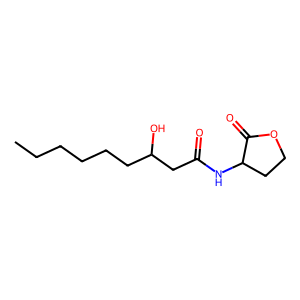

In [25]:
from rdkit.Chem import Draw

img = Draw.MolToImage(s_new_mol)
img

In [ ]:
for  s in new_frags:
    img = Draw.MolToImage(Chem.MolFromSmiles(s))
    display(img)

AttributeError: 'Boost.Python.function' object has no attribute 'GetAtomWithIdx'